Rafał Gołębiowski

# Wygenerować przykładowe dane.

In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy import stats
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import naive_bayes
from sklearn import discriminant_analysis
from sklearn import svm
from sklearn import tree
from sklearn import metrics
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time
import warnings
warnings.filterwarnings("ignore")

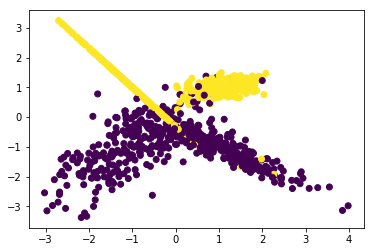

In [2]:
X, y = make_classification(n_samples=1000,
                    n_features=2, n_informative=2, 
                    n_redundant=0, n_repeated=0, 
                    n_classes=2, n_clusters_per_class=2)
plt.scatter(X[: , 0], X[:, 1], c = y)
plt.show()

# Utworzyć listę klasyfikatorów.

In [3]:
classificators = [naive_bayes.GaussianNB(),
                discriminant_analysis.QuadraticDiscriminantAnalysis(),
                svm.SVC(probability=True, gamma="auto"),
                tree.DecisionTreeClassifier()]

# Utworzyć słownik z przestrzenią parametrów.

In [4]:
params = {}
params[classificators[0]] = {'var_smoothing': np.logspace(-5, 5, 100)}
params[classificators[1]] = {'reg_param': np.logspace(-15, 1, 10),
                            'tol': np.logspace(-15, 1, 10)}
params[classificators[2]] = {'kernel': ('linear', 'rbf'),
                            'C': range(1, 10)}
params[classificators[3]] = {'criterion': ["gini", "entropy"],
                            'max_depth': range(5, 50, 5)}

# Dla każdego z klasyfikatorów dobrać parametry optymalne z zadanej przestrzeni parametrów.

In [5]:
gss =[]
for j, classificator in enumerate(classificators):
    gs = GridSearchCV(classificator, params[classificator], 'accuracy', cv = 5)
    gs.fit(X, y)

    classificator.set_params(**gs.best_params_)
    print(gs.best_params_)

    gss.append(gs)


{'var_smoothing': 0.22051307399030456}
{'reg_param': 1e-15, 'tol': 1e-15}
{'C': 4, 'kernel': 'rbf'}
{'criterion': 'entropy', 'max_depth': 5}


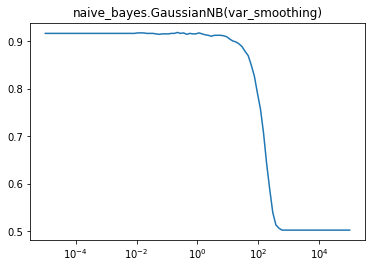

In [6]:
plt.semilogx(np.logspace(-5, 5, 100), gss[0].cv_results_['mean_test_score'])
plt.title("naive_bayes.GaussianNB(var_smoothing)")
plt.show()

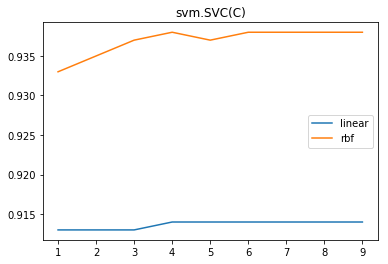

In [7]:
plt.plot(range(1, 10), gss[2].cv_results_['mean_test_score'][::2])
plt.plot(range(1, 10), gss[2].cv_results_['mean_test_score'][1::2])
plt.title("svm.SVC(C)")
plt.legend(['linear', 'rbf'])
plt.show()

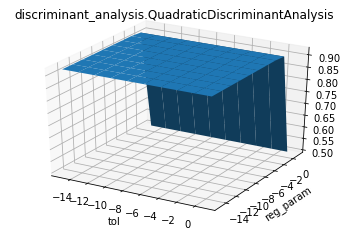

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d')

XX = np.logspace(-15, 1, 10)
YY = np.logspace(-15, 1, 10)
XX, YY = np.meshgrid(XX, YY)

# Plot the surface.
ax.plot_surface(np.log10(XX), np.log10(YY), gss[1].cv_results_['mean_test_score'].reshape((10, 10)))
ax.set_xlabel('tol')
ax.set_ylabel('reg_param')
plt.title("discriminant_analysis.QuadraticDiscriminantAnalysis")
plt.show()

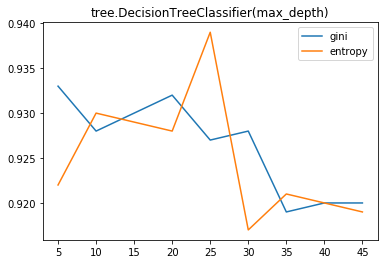

In [9]:
plt.plot(range(5, 50, 5), gss[3].cv_results_['mean_test_score'][::2])
plt.plot(range(5, 50, 5), gss[3].cv_results_['mean_test_score'][1::2])
plt.title("tree.DecisionTreeClassifier(max_depth)")
plt.legend(['gini', 'entropy'])
plt.show()

# Dla parametrów optymalnych podzielić 100 razy dane na część uczącą i testującą poleceniem train_test_split, następnie dla każdego z klasyfikatorów wykonać uczenie na zbiorze uczącym (metoda fit(X_train, y_train)), a następnie wyznaczyć predykcje na zbiorze testowym:
## Na podstawie y_pred oraz y_test wyznaczyć: czas uczenia i testowania oraz miary jakości klasyfikacji:
## Narysować powierzchnię dyskryminacyjną na tle próbek testowych

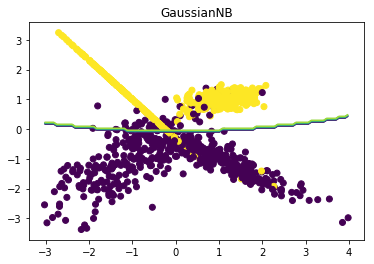

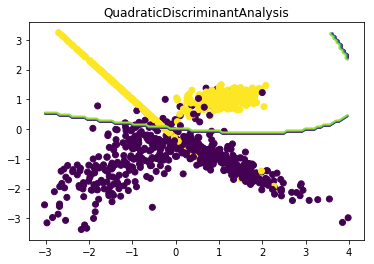

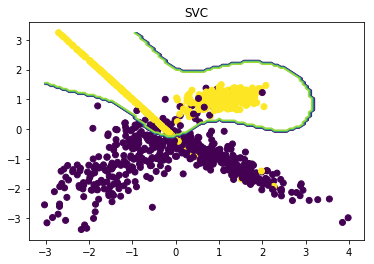

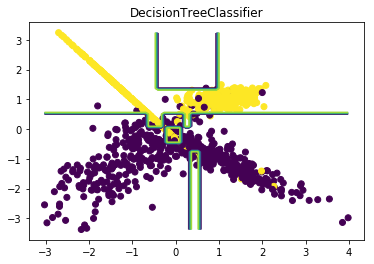

In [10]:
df = pd.DataFrame(columns=["Classificator", 
                        "Accuracy",
                        "Recall",
                        "Precision",
                        "F1",
                        "ROC",
                        "trainTime",
                        "testTime"])
    
loops = 100
classificatorsCount = len(classificators)

fprs = []
tprs = []

for i in range(loops):
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.5, random_state=i)
    
    for j, classificator in enumerate(classificators):
        trainTime = time()
        classificator.fit(XTrain, yTrain)
        trainTime = time() - trainTime
        testTime = time()
        yPredicted = classificator.predict(XTest)
        testTime = time() - testTime

        row = [classificator.__class__.__name__]
        row.append(metrics.accuracy_score(yTest, yPredicted))
        row.append(metrics.recall_score(yTest, yPredicted))
        row.append(metrics.precision_score(yTest, yPredicted))
        row.append(metrics.f1_score(yTest, yPredicted))
        row.append(metrics.roc_auc_score(yTest, yPredicted))
        row.append(trainTime)
        row.append(testTime)
        df.loc[i * classificatorsCount + j] = row
        
        if(i == loops - 1):
            prPred = classificator.predict_proba(XTest)
            auc = metrics.roc_auc_score(yTest, prPred[:, 1])

            fpr, tpr, thresholds = metrics.roc_curve(yTest, prPred[:, 1])

            fprs.append(fpr)
            tprs.append(tpr)

            plt.scatter(X[: , 0], X[:, 1], c = y)
            XX, YY = np.meshgrid(np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100), np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100))
            Z = classificator.predict(np.vstack([XX.ravel(), YY.ravel()]).T)
            plt.contour(XX, YY, np.reshape(Z, (100, 100)))
            plt.title(classificator.__class__.__name__)
            plt.show()

# Krzywe roc

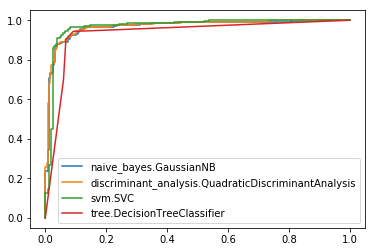

In [11]:
for j in range(classificatorsCount):
    plt.plot(fprs[j], tprs[j])
plt.legend(['naive_bayes.GaussianNB',
            'discriminant_analysis.QuadraticDiscriminantAnalysis',
            'svm.SVC',
            'tree.DecisionTreeClassifier'])
plt.show()

# Wyniki zebrać w tabeli DataFrame, natępnie zgrupować po rodzaju klasyfikatora oraz uśrednić.

In [12]:
 print(df.groupby("Classificator").mean())

                               Accuracy    Recall  Precision        F1  \
Classificator                                                            
DecisionTreeClassifier          0.92678  0.943931   0.913200  0.927940   
GaussianNB                      0.91548  0.932965   0.901585  0.916832   
QuadraticDiscriminantAnalysis   0.91846  0.914128   0.922269  0.917996   
SVC                             0.93430  0.947000   0.923658  0.935059   

                                    ROC  trainTime  testTime  
Classificator                                                 
DecisionTreeClassifier         0.926826   0.000878  0.000140  
GaussianNB                     0.915636   0.000528  0.000159  
QuadraticDiscriminantAnalysis  0.918529   0.000468  0.000130  
SVC                            0.934333   0.010972  0.000978  


Wszystkie klasyfikatory poradziły sobie podobnie. Najlepszy okazał się SVC, jednak jego czasy uczenia i testowania znacznie przewyższają czasy innych klasyfikatorów.